# Preprocessing Load Data

Import all dependencies

In [14]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install numpy
!pip install datetime




Make all necessary imports

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import sys


Preprocessing Function

In [25]:
def preprocess_load_data(file_path):
    """
    Preprocess the aggregated load data from ERCOT.
    
    Args:
        file_path (str): Path to the raw load data CSV file
        
    Returns:
        pd.DataFrame: Processed load data
    """
    # Read the data
    load_df = pd.read_csv(file_path)
    
    # Convert SCED Time Stamp to datetime
    load_df['SCED Time Stamp'] = pd.to_datetime(load_df['SCED Time Stamp'])
    
    # Extract date and time components
    load_df['Date'] = load_df['SCED Time Stamp'].dt.date
    load_df['Hour'] = load_df['SCED Time Stamp'].dt.hour
    load_df['Minute'] = load_df['SCED Time Stamp'].dt.minute
    
    # Create a proper datetime index
    load_df.set_index('SCED Time Stamp', inplace=True)
    
    return load_df

In [ ]:
project_root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(project_root)
input_file = os.path.join(project_root, 'data', 'raw', 'load', '2d_Agg_Load_Summary-17-APR-25.csv')
f


preprocess_load_data(input_file)

,Repeated Hour Flag,SUM TELEM GEN MW,SUM TELEM DCTIE MW,AGG LOAD SUMMARY,Date,Hour,Minute
SCED Time Stamp,,,,,,,
2025-04-15 00:00:13,N,49449.75908,4.8,49444.95908,2025-04-15,0,0
2025-04-15 00:15:12,N,47823.36693,17.1,47806.26693,2025-04-15,0,15
2025-04-15 00:30:11,N,46989.60012,17.2,46972.40012,2025-04-15,0,30
2025-04-15 00:45:13,N,46556.72499,17.6,46539.12499,2025-04-15,0,45
2025-04-15 01:00:14,N,46270.94239,16.7,46254.24239,2025-04-15,1,0
...,...,...,...,...,...,...,...
2025-04-15 22:45:09,N,49065.31658,-158.4,49223.71658,2025-04-15,22,45
2025-04-15 23:00:12,N,48732.35007,-158.5,48890.85007,2025-04-15,23,0
2025-04-15 23:15:09,N,47988.89619,-158.5,48147.39619,2025-04-15,23,15


In [ ]:
# Suppose your load_df and price_df already have a 'Datetime' column with seconds/minutes
# Floor both to the hour
load_df['Datetime_hour'] = load_df['Datetime'].dt.floor('H')
price_df['Datetime_hour'] = price_df['Datetime'].dt.floor('H')


merged = pd.merge(load_df, price_df, left_on='Datetime_hour', right_on='Datetime_hour', how='inner')


merged.columns

<ipython-input-10-3c6200577d97>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  load_df['Datetime_hour'] = load_df['Datetime'].dt.floor('H')
<ipython-input-10-3c6200577d97>:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  price_df['Datetime_hour'] = price_df['Datetime'].dt.floor('H')
<ipython-input-10-3c6200577d97>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_df['Datetime_hour'] = price_df['Datetime'].dt.floor('H')


Index(['SCED Time Stamp', 'Repeated Hour Flag', 'SUM TELEM GEN MW',
       'SUM TELEM DCTIE MW', 'AGG LOAD SUMMARY', 'Datetime_x', 'Datetime_hour',
       'DeliveryDate', 'HourEnding', 'SettlementPoint', 'SettlementPointPrice',
       'DSTFlag', 'Datetime_y'],
      dtype='object')

In [ ]:
# --- 1. Feature Engineering ---
# Sort by datetime for proper time-series operations
merged = merged.sort_values('Datetime_hour')

# Create load ramp (change in load from previous hour)
merged['load_ramp'] = merged['AGG LOAD SUMMARY'].diff()

# Create supply-demand balance features
merged['load_gen_ratio'] = merged['AGG LOAD SUMMARY'] / merged['SUM TELEM GEN MW']
merged['load_minus_gen'] = merged['AGG LOAD SUMMARY'] - merged['SUM TELEM GEN MW']
merged['tie_flow_pct'] = merged['SUM TELEM DCTIE MW'] / merged['AGG LOAD SUMMARY']

# Create time features
merged['hour'] = merged['Datetime_hour'].dt.hour
merged['day_of_week'] = merged['Datetime_hour'].dt.dayofweek
merged['is_peak_hour'] = ((merged['hour'] >= 16) & (merged['hour'] <= 20)).astype(int)

# Create rolling averages (important from feature importance plot)
merged['3hr_load_ma'] = merged['AGG LOAD SUMMARY'].rolling(window=3).mean()
merged['6hr_load_ma'] = merged['AGG LOAD SUMMARY'].rolling(window=6).mean()
merged['3hr_gen_ma'] = merged['SUM TELEM GEN MW'].rolling(window=3).mean()

# Handle missing values and infinities
merged.replace([np.inf, -np.inf], np.nan, inplace=True)
merged.dropna(inplace=True)

merged

,SCED Time Stamp,Repeated Hour Flag,SUM TELEM GEN MW,SUM TELEM DCTIE MW,AGG LOAD SUMMARY,Datetime_x,Datetime_hour,DeliveryDate,HourEnding,SettlementPoint,...,load_ramp,load_gen_ratio,load_minus_gen,tie_flow_pct,hour,day_of_week,is_peak_hour,3hr_load_ma,6hr_load_ma,3hr_gen_ma
27,04/15/2025 01:45:12,N,45031.10593,17.1,45014.00593,2025-04-15 01:45:12,2025-04-15 01:00:00,04/15/2025,01:00,LZ_LCRA,...,0.00000,0.999620,-17.1,0.000380,1,1,0,45014.005930,45220.712007,45031.10593
26,04/15/2025 01:45:12,N,45031.10593,17.1,45014.00593,2025-04-15 01:45:12,2025-04-15 01:00:00,04/15/2025,01:00,LZ_HOUSTON,...,0.00000,0.999620,-17.1,0.000380,1,1,0,45014.005930,45014.005930,45031.10593
25,04/15/2025 01:45:12,N,45031.10593,17.1,45014.00593,2025-04-15 01:45:12,2025-04-15 01:00:00,04/15/2025,01:00,LZ_CPS,...,0.00000,0.999620,-17.1,0.000380,1,1,0,45014.005930,45014.005930,45031.10593
24,04/15/2025 01:45:12,N,45031.10593,17.1,45014.00593,2025-04-15 01:45:12,2025-04-15 01:00:00,04/15/2025,01:00,LZ_AEN,...,0.00000,0.999620,-17.1,0.000380,1,1,0,45014.005930,45014.005930,45031.10593
22,04/15/2025 01:30:12,N,45194.41963,17.5,45176.91963,2025-04-15 01:30:12,2025-04-15 01:00:00,04/15/2025,01:00,LZ_SOUTH,...,162.91370,0.999613,-17.5,0.000387,1,1,0,45068.310497,45041.158213,45085.54383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,04/15/2025 23:00:12,N,48732.35007,-158.5,48890.85007,2025-04-15 23:00:12,2025-04-15 23:00:00,04/15/2025,23:00,LZ_CPS,...,0.00000,1.003252,158.5,-0.003242,23,1,0,48890.850070,48890.850070,48732.35007
704,04/15/2025 23:00:12,N,48732.35007,-158.5,48890.85007,2025-04-15 23:00:12,2025-04-15 23:00:00,04/15/2025,23:00,LZ_AEN,...,0.00000,1.003252,158.5,-0.003242,23,1,0,48890.850070,48890.850070,48732.35007
734,04/15/2025 23:45:10,N,47127.45501,-158.7,47286.15501,2025-04-15 23:45:10,2025-04-15 23:00:00,04/15/2025,23:00,LZ_SOUTH,...,-1604.69506,1.003367,158.7,-0.003356,23,1,0,48355.951717,48623.400893,48197.38505
718,04/15/2025 23:15:09,N,47988.89619,-158.5,48147.39619,2025-04-15 23:15:09,2025-04-15 23:00:00,04/15/2025,23:00,LZ_SOUTH,...,861.24118,1.003303,158.5,-0.003292,23,1,0,48108.133757,48499.491913,47949.56709


In [ ]:
# --- 2. Select Features and Target ---
features = merged[[
    'AGG LOAD SUMMARY',
    'SUM TELEM GEN MW',
    'SUM TELEM DCTIE MW',
    'load_ramp',
    'load_gen_ratio',
    'load_minus_gen',
    'tie_flow_pct',
    'hour',
    'day_of_week',
    'is_peak_hour',
    '3hr_load_ma',
    '6hr_load_ma',
    '3hr_gen_ma'
]]

target = merged['SettlementPointPrice']


In [ ]:
# --- 3. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# --- 4. Train Random Forest Model ---
model = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Random Forest Model Performance:
MAE: $4.41/MWh
RMSE: $6.38/MWh
R2: 0.8610


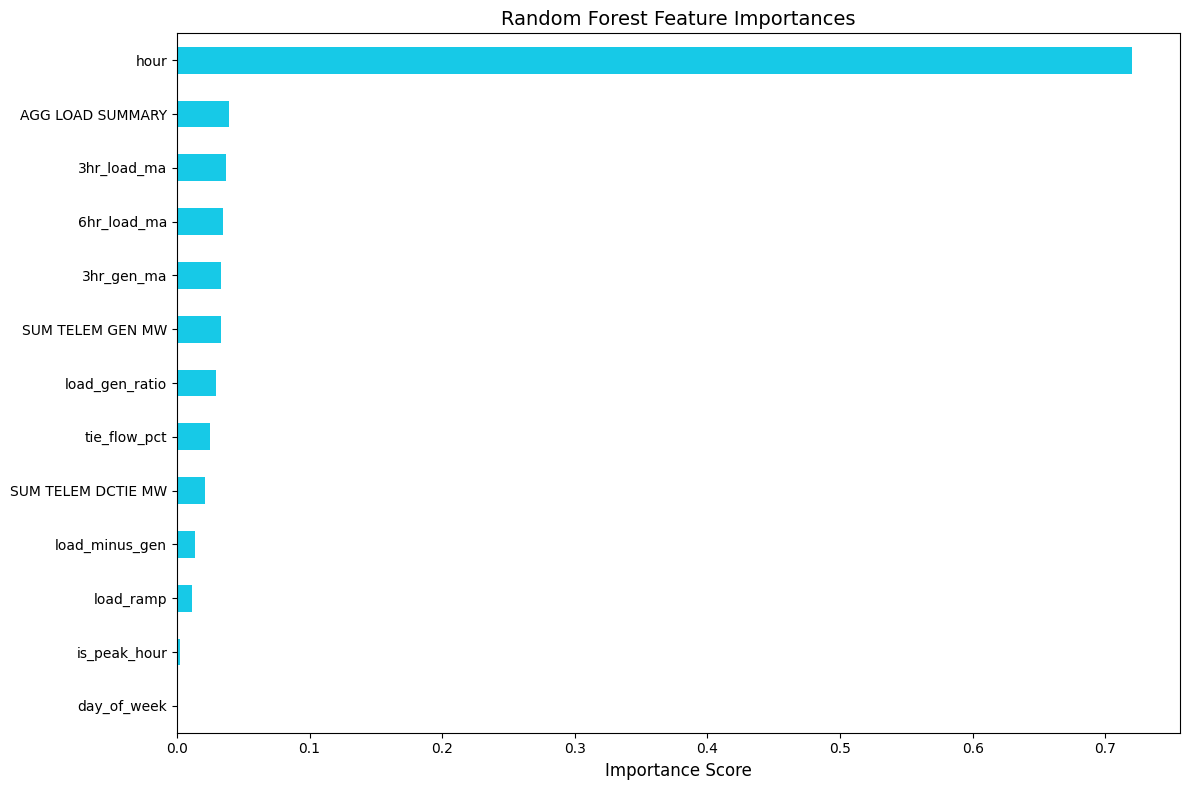

In [ ]:
# --- 5. Evaluate ---
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print('Random Forest Model Performance:')
print(f'MAE: ${mae:.2f}/MWh')
print(f'RMSE: ${rmse:.2f}/MWh')
print(f'R2: {r2:.4f}')

# --- 6. Plot Feature Importances ---
plt.figure(figsize=(12, 8))
importances = pd.Series(model.feature_importances_, index=features.columns)
importances = importances.sort_values(ascending=True)
importances.plot(kind='barh', color="#17c9e7")
plt.title('Random Forest Feature Importances', fontsize=14)
plt.xlabel('Importance Score', fontsize=12)
plt.tight_layout()
plt.show()
